In [1]:
import sys
PATH_FOR_PROJECT = "/home/louis/Dropbox/ConsultationSimpliphAI/" \
           "AnalytiqueBourassaGit/UncertaintyForecasting/"
sys.path.append(PATH_FOR_PROJECT)

In [2]:
from tqdm import tqdm

In [3]:
from models.training_tools.early_stopping import EarlyStopping
from models.script_parameters.parameters import ExperimentParameters

In [4]:
PATH_LOCAL = "models/regression/LSTM_BayesRegressor/"

In [5]:
early_stopper = EarlyStopping(patience=4, verbose=True)

experiment_params = ExperimentParameters()

experiment_params.path = PATH_FOR_PROJECT + PATH_LOCAL + ".models/"
path_results = PATH_FOR_PROJECT + PATH_LOCAL


experiment_params.version = "v0.0.7"
experiment_params.show_figures = False
experiment_params.smoke_test = True
experiment_params.train_lstm = True
experiment_params.save_lstm = True
experiment_params.type_of_data = "autoregressive-5" # options are sin or "autoregressive-5"
experiment_params.name = "feature_extractor_" + experiment_params.type_of_data

In [6]:
n_data = 1000
length_of_sequences = 7 + 1

# 2. Data generation

In [7]:
from math import floor

In [8]:
from data_generation.data_generators_switcher import DatageneratorsSwitcher
from data_handling.data_reshaping import reshape_data_for_LSTM, reshape_into_sequences
from visualisations.visualisations import Visualisator

In [9]:
size_of_training_set = 0.5
size_of_training_and_val_set = 0.7

In [10]:
data_generator = DatageneratorsSwitcher(experiment_params.type_of_data)
data = data_generator(n_data)

sequences = reshape_into_sequences(data, length_of_sequences)
all_data = reshape_data_for_LSTM(sequences)

training_data_labels = all_data[length_of_sequences-1, :, 0]

number_of_train_data = floor(size_of_training_set*n_data)
val_set_end = floor(size_of_training_and_val_set*n_data)

data_train = all_data[:, :number_of_train_data, :]
data_validation = all_data[:, number_of_train_data:val_set_end, :]

if experiment_params.show_figures:
    Visualisator.show_time_series(data=all_data[length_of_sequences-2, :, 0],
                                  title="Data generated using an ARMA(4,2) process")

# 3. Training of the feature extractor (LSTM)

In [11]:
from models.lstm_params import LSTM_parameters
from models.regression.LSTM_BayesRegressor.LSTM import LSTM

In [12]:
from models.model_data_feeder import *
from models.disk_reader_and_writer import save_checkpoint, load_checkpoint

In [13]:
from sklearn.metrics import mean_squared_error

In [14]:
lstm_params = LSTM_parameters()

if experiment_params.train_lstm is False:
    lstm_params.load("lstm_params_" + experiment_params.name + "_" + experiment_params.version, experiment_params.path)
    
lstm_params.batch_size = 50
lstm_params.hidden_dim = 5
lstm_params.dropout = 0.4

In [15]:
learning_rate = 1e-3
num_epochs = 2300 if not experiment_params.smoke_test else 1
epoch_interval_for_loss_tracking =100

In [16]:
model = LSTM(lstm_params)
model.cuda()

/home/louis/anaconda3/envs/env_UncertaintyForecasting/lib/python3.6/site-packages/torch/nn/modules/rnn.py:54: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.4 and num_layers=1
  "num_layers={}".format(dropout, num_layers))


LSTM(
  (lstm): LSTM(1, 5, dropout=0.4)
  (linear): Linear(in_features=5, out_features=1, bias=True)
)

In [17]:
loss_fn = torch.nn.MSELoss(size_average=False)
optimizer = torch.optim.Adam(model.parameters(),
                             lr=learning_rate)

/home/louis/anaconda3/envs/env_UncertaintyForecasting/lib/python3.6/site-packages/torch/nn/_reduction.py:46: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


In [18]:
if experiment_params.train_lstm:
    hist = np.zeros(num_epochs)
    for epoch in tqdm(range(num_epochs)):
        model.hidden = model.init_hidden()

        losses, N_data = make_forward_pass(data_loader_sequences, model, loss_fn, data_train, lstm_params.batch_size)

        if epoch % epoch_interval_for_loss_tracking == 0:
            y_pred, y_true = make_predictions(data_loader_sequences, model, data_validation, lstm_params.batch_size)
            val_loss = mean_squared_error(y_pred, y_true)
            print("Epoch ", epoch, "MSE: ", val_loss)
            early_stopper(epoch, val_loss, model)

            if early_stopper.early_stop:
                break

        hist[epoch] = losses.item()

        optimizer.zero_grad()
        losses.backward()
        optimizer.step()
else:

    load_checkpoint(model, optimizer, experiment_params.path,
                    experiment_params.name + "_" + experiment_params.version)

if experiment_params.save_lstm:
    save_checkpoint(model, optimizer, experiment_params.path,
                    experiment_params.name + "_" + experiment_params.version)
    lstm_params.save(experiment_params.version, experiment_params.path)

y_pred, _ = make_predictions(data_loader_sequences, model, all_data, lstm_params.batch_size)
features, y_true = extract_features(data_loader_sequences, model, all_data, lstm_params.batch_size)

100%|██████████| 1/1 [00:00<00:00, 22.38it/s]

Epoch  0 MSE:  0.253268


# 4. Results of feature extractor

In [19]:
from sklearn.metrics import r2_score

In [20]:
print("r2 score: %.4f" % r2_score(y_true.flatten(), y_pred.flatten()))
print("r2 score for naive forecaster: %.4f" % r2_score(y_true[1:].flatten(), y_true[:-1].flatten()))

r2 score: -1.4900
r2 score for naive forecaster: 0.3473


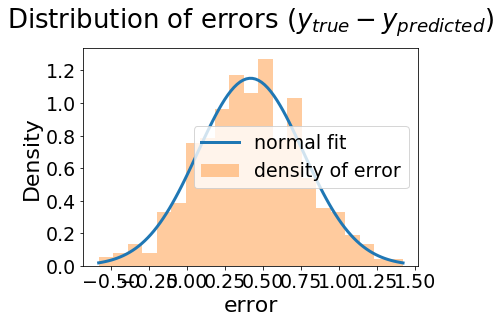

In [21]:
errors = y_true.flatten() - y_pred.flatten()

Visualisator.show_distribution(data=errors,
                               title="Distribution of errors ($y_{true} - y_{predicted}$)",
                               normal_fit=True,
                               name="error")

In [22]:
if experiment_params.show_figures:
    Visualisator.show_predictions(y_pred, y_true)

    if experiment_params.train_lstm:
        Visualisator.show_epoch_convergence(data=hist,
                                            name="Loss",
                                            title="Loss convergence curve for the LSTM training")


# 5. Probabilistic model

In [23]:
from models.regression.LSTM_BayesRegressor.bayesian_linear_regression.bayesian_linear_regression import BayesianLinearModel

Average Loss = 1,939.1: 100%|██████████| 1/1 [00:00<00:00, 285.83it/s]
Finished [100%]: Loss = 1,939.1


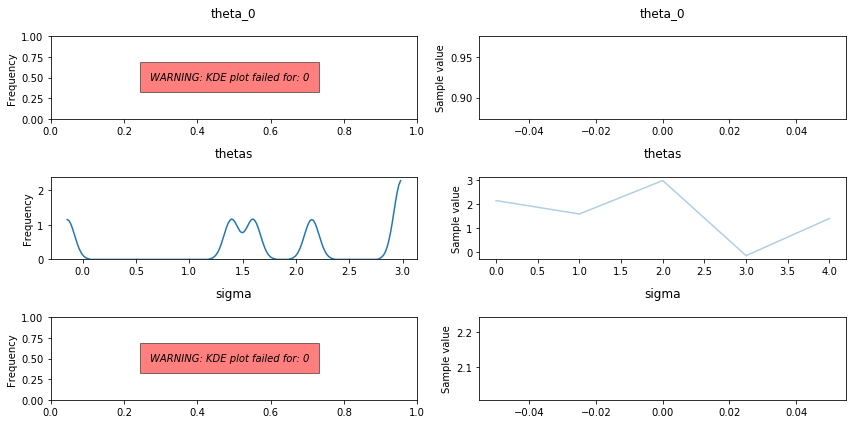

100%|██████████| 1/1 [00:00<00:00, 13.18it/s]


In [24]:
number_of_train_data = floor(size_of_training_and_val_set*n_data)
X_train, X_test, y_train, y_test = features[:number_of_train_data], features[number_of_train_data:], \
                                   y_true[:number_of_train_data], y_true[number_of_train_data:]

model.cpu()
priors_beta, _ = model.last_layers_weights

model_linear_mcmc = BayesianLinearModel(X_train,
                                        y_train,
                                        priors_beta,
                                        SMOKE_TEST=experiment_params.smoke_test)

model_linear_mcmc.option = "ADVI-full-rank"
model_linear_mcmc.sample()
model_linear_mcmc.show_trace()

predictions = model_linear_mcmc.make_predictions(X_test, y_test)

# 6. Analysis of probabilistic predictions

In [25]:
from models.calibration.analysis import show_analysis
from models.calibration.diagnostics import *

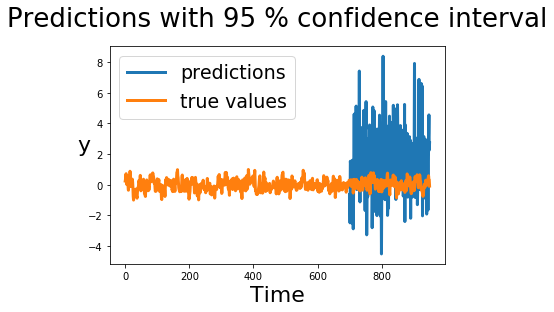

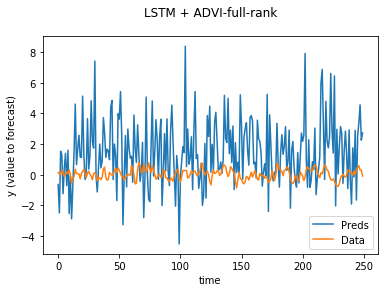

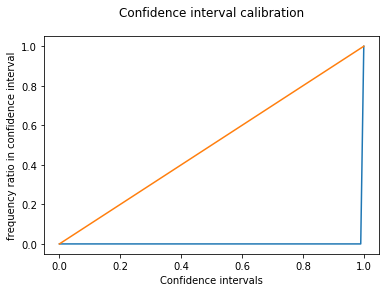

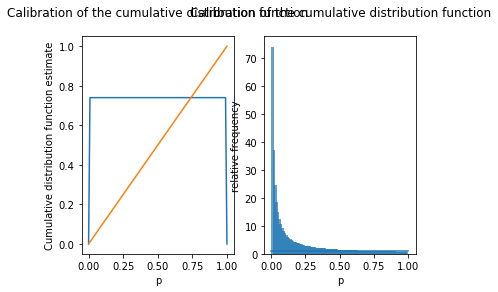

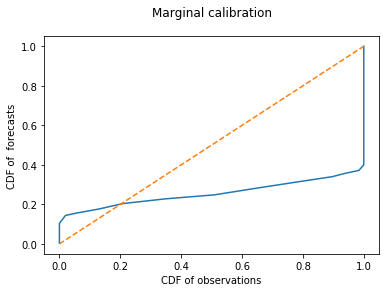

 deviation_score_probabilistic_calibration: 0.49500 
 deviation_score_exceedance_calibration: 0.31260 
 deviation_score_marginal_calibration: 0.30795 


In [26]:
deviation_score_probabilistic_calibration = calculate_confidence_interval_calibration(predictions.values, predictions.true_values)
deviation_score_exceedance_calibration = calculate_one_sided_cumulative_calibration(predictions.values, predictions.true_values)
deviation_score_marginal_calibration = calculate_marginal_calibration(predictions.values, predictions.true_values)

predictions.train_data = y_train
predictions.show_predictions_with_training_data(confidence_interval=0.95)

show_analysis(predictions.values, predictions.true_values, name="LSTM + " + model_linear_mcmc.option)